In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [2]:
torch.manual_seed(42)

In [3]:
df = pd.read_csv("/kaggle/input/mnist-small-6k/fmnist_small - fmnist_small.csv")

In [4]:
df.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


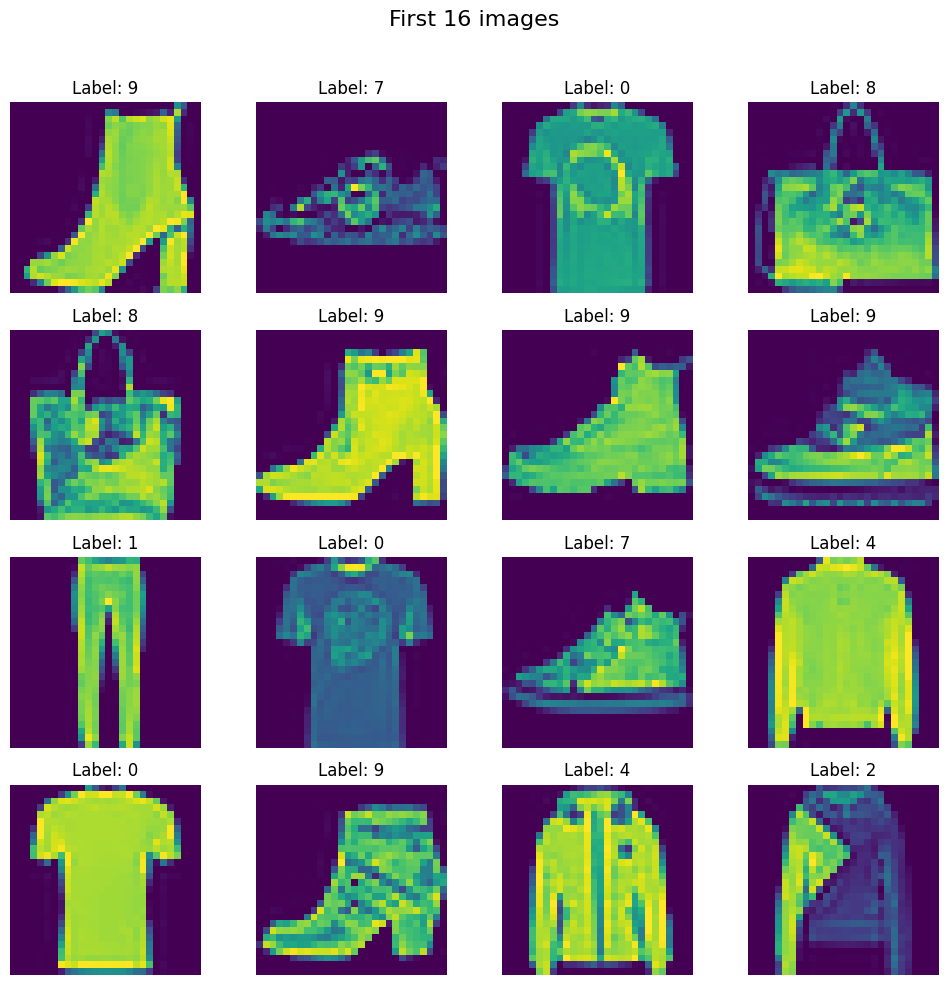

In [5]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 images", fontsize=16)


for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"Label: {df.iloc[i, 0]}")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


In [6]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# scaling the features

X_train = X_train/255.0
X_test = X_test/255.0

In [9]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [10]:
train_data = CustomDataset(X_train, y_train)
test_data = CustomDataset(X_test,  y_test)

In [11]:
train_loader = DataLoader(train_data, batch_size= 32, shuffle=True)
test_loader = DataLoader(test_data, batch_size= 32, shuffle=False)

In [12]:
class NeuralNet(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 10)
        )

    def forward(self, x):
        return self.model(x)

In [13]:
epochs = 100
learning_rate = 0.1

In [14]:
model = NeuralNet(num_features = X_train.shape[1])

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
def train(num_epochs):
    best_accuracy = 0.0
    for epoch in range(1, num_epochs):
        running_train_loss = 0.0
        running_accuracy = 0.0
        total = 0.0
        running_val_loss = 0.0

        for data in train_loader:
            inputs, outputs = data
            y_pred = model(inputs)
            optimizer.zero_grad()  # clearing the gradients
            train_loss = loss_function(y_pred, outputs)

            train_loss.backward()
            optimizer.step() # updating the gradients
            running_train_loss += train_loss.item()   # tracks the loss value
        avg_train_loss = running_train_loss / len(train_loader)

        with torch.no_grad():
            model.eval()
            for batch_feat, batch_labels in test_loader:
                predictions = model(batch_feat)
                val_loss = loss_function(predictions, batch_labels)
                _, predicted = torch.max(predictions, 1)

                running_val_loss += val_loss.item()
                total += batch_labels.size(0)

                running_accuracy += (predicted == batch_labels).sum().item()
            val_loss_value = running_val_loss / len(test_loader)

        accuracy = running_accuracy / total

        if accuracy > best_accuracy:
            best_accuracy = accuracy


        print(f"Epoch: {epoch}, train_loss: {avg_train_loss}, val_loss: {val_loss_value}, accuracy: {accuracy}")

                
                
            

In [16]:
train(num_epochs=epochs)

Epoch: 1, train_loss: 1.8815710997581483, val_loss: 1.3476344472483586, accuracy: 0.47833333333333333
Epoch: 2, train_loss: 1.040725481112798, val_loss: 0.8864145655381052, accuracy: 0.6366666666666667
Epoch: 3, train_loss: 0.8272622509797414, val_loss: 0.8067515288528643, accuracy: 0.6808333333333333
Epoch: 4, train_loss: 0.7038348545630773, val_loss: 0.6705642028858787, accuracy: 0.7425
Epoch: 5, train_loss: 0.6404025133450826, val_loss: 0.6569188433258157, accuracy: 0.7475
Epoch: 6, train_loss: 0.592077908317248, val_loss: 0.6764127055281087, accuracy: 0.745
Epoch: 7, train_loss: 0.5481052520871162, val_loss: 0.6069247259905464, accuracy: 0.7691666666666667
Epoch: 8, train_loss: 0.524915909965833, val_loss: 0.5321646191571888, accuracy: 0.81
Epoch: 9, train_loss: 0.4827703426281611, val_loss: 0.5118396019465045, accuracy: 0.8266666666666667
Epoch: 10, train_loss: 0.4702054068446159, val_loss: 0.6148045510053635, accuracy: 0.7783333333333333
Epoch: 11, train_loss: 0.43500154654184975